<a id='top'></a>
<img style="float: center;" src='https://github.com/STScI-MIRI/MRS-ExampleNB/raw/main/assets/banner1.png' alt="stsci_logo" width="1000px"/>

# NIRSpec MOS MSA Metafile

**Authors**: Dan Coe (dcoe@stsci.edu) and Kayli Glidic (kglidic@stsci.edu) with contributions from others on the STScI NIRSpec team. <br>
**Created On**: June, 2024 ([JWebbinar 33](https://www.stsci.edu/jwst/science-execution/jwebbinars.html#h3-dc1c3cd6-f1aa-45c4-b73f-e93cc96ff4a7:~:text=33%20%2D%20JWST%20NIRSpec%20MOS%20Data%20Reduction))<br>
**Updated On**: November, 2025. <br>

**Purpose**:<br> The primary goal of this notebook is to explore the Micro-Shutter Assembly (MSA) metadata file, an essential file for calibrating Near Infrared Spectrograph (NIRSpec) Multi-Object Spectroscopy (MOS) observations with the *James Webb Space Telescope* (JWST) Calibration Pipeline.

**[Data](#data)**:<br>
This notebook is set up to use the MSA metadata file from [ERO 2736](https://www.stsci.edu/cgi-bin/get-proposal-info?observatory=JWST&id=2736) observations of [SMACS0723](https://webbtelescope.org/contents/news-releases/2022/news-2022-035).

---

## Table of Contents
* [1. Introduction](#intro)
* [2. Import Library](#imports)
* [3. Helper Functions](#funcs)
* [4. Download the MSA Metafile](#data)
* [5. Load the MSA Metafile and Inspect Contents](#content)
    * [5.1 Source Table](#source_table)
    * [5.2 Shutter Table](#shutter_table)
    * [5.3 Shutter Image](#shutter_image)
        * [5.3.1 Shutter Image from MSA Metadata File](#image_meta)
        * [5.3.2 Shutter Image from Shutter Table](#image_table)
        * [5.3.3 Shutter Image from APT](#image_apt)
* [6. Modifying the MSA Metadata File](#modify)
* [7. Link to Files in Preparation for Pipeline](#pipeline)





























---
  
## 1. Introduction <a id='intro'></a>


The [MSA metadata file](https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/msa_metadata.html) records information about NIRSpec [MOS](https://jwst-docs.stsci.edu/jwst-near-infrared-spectrograph/nirspec-observing-modes/nirspec-multi-object-spectroscopy) [MSA](https://jwst-docs.stsci.edu/jwst-near-infrared-spectrograph/nirspec-instrumentation/nirspec-micro-shutter-assembly) configurations as planned by [APT](https://jwst-docs.stsci.edu/jwst-astronomer-s-proposal-tool-overview)'s [MSA Planning Tool (MPT)](https://jwst-docs.stsci.edu/jwst-near-infrared-spectrograph/nirspec-apt-templates/nirspec-multi-object-spectroscopy-apt-template/nirspec-msa-planning-tool-mpt). This file details which shutters were planned to be opened, how the shutters were configured into slitlets, and which targets were assigned to each slitlet. The JWST *[`calwebb_spec2`](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_spec2.html)* pipeline uses the MSA metadata file to extract spectra from sources. The overall structure of the MSA FITS file is as follows:

* `SHUTTER_IMAGE` (2D array): A map showing which MSA shutters were open or closed during the observation.
* `SHUTTER_INFO` (table): Detailed information for each shutter, including whether it is part of a longer slit (slitlet), if it contains a science target or empty background, etc.
* `SOURCE_INFO` (table): A catalog of science targets plus fake targets in empty slits.


In the remainder of this notebook, we explore the contents of the MSA metadata file in more detail. We also demonstrate how to edit the file for:

* a subset of sources,
* science vs. background shutters, and
* point source vs. extended targets (used by the pathloss correction),

Finally, we also show how to view the shutter image map.






---

## 2. Import Library <a id='imports'></a>


In [1]:
# Import libraries.

# General imports.
import os
import csv
import copy
import requests
import numpy as np
from glob import glob

# Plotting imports.
import matplotlib.pyplot as plt
import matplotlib as mpl
#%matplotlib notebook  # interactive plots
%matplotlib inline

# Astropy/query imports.
import astroquery
from astropy.io import fits
from astropy.table import Table
from astroquery.mast import Observations
print('astroquery version', astroquery.__version__)

astroquery version 0.4.11


---

## 3. Helper Functions <a id='funcs'></a>

These helper functions perform basic tasks like checking values, filtering data, and managing files.

In [2]:
def even(x):
    """
    Even or odd number.

    Parameters
    ----------
    x : int
        Integer to be tested.
    
    Returns
    -------
    value : int
        1 = even; 0 = odd
    """
    return 1 - x % 2


def single_value(x):
    """
    Determine whether the input is a single integer or float.
    True = one number; False = multiple numbers (list / tuple / array / set).

    Parameters
    ----------
    x : int, float, list, tup, etc

    Returns
    -------
    value : bool
        True if x is an integer or float. Otherwise false.
    """
    return isinstance(x, (int, float))


def filter_table(full_table, **kwargs):
    """
    Filters an Astropy Table based an arbitrary number of input column-value pairs.
    Each value can be either a single value or a list (or tuple, array, or set).
    Example:
    select_shutter_table = filter_table(shutter_table, msa_metadata_id=1, dither_point_index=1, source_id=[6355,5144])

    Parameters
    ----------
    full_table : astropy.table.Table
        Table to be filtered.

    Returns
    -------
    filtered_table : astropy.table.Table
        Table containing only requested columns/values.
    """
    filtered_table = full_table
    for column, value in kwargs.items():
        if single_value(value):
            filtered_table = filtered_table[filtered_table[column] == value]
        else: # list
            filtered_table = filtered_table[[(item in value) for item in filtered_table[column]]]
    return filtered_table


# Create links in output_dir directory to source files.
def link_to_files(source_files,
                  output_dir):
    """
    Create symlinks to the given source_files in the output_dir directory.

    Parameters
    ----------
    source_files : list
        List of filenames.
    output_dir : str
        Directory in which to create symlinks.
    """
    for source_file in source_files:
        link = os.path.join(output_dir, os.path.basename(source_file))
        print(link, '->', source_file)
        if not os.path.exists(link):
            os.symlink(os.path.abspath(source_file), link)

Below, we define a couple of functions to download data products from MAST.

In [3]:
# Helper function to download JWST files from MAST.
def download_jwst_files(filenames,
                        download_dir,
                        mast_dir='mast:jwst/product'):
    """
    Helper function to download JWST files from MAST.

    Parameters:
    ----------
    filenames: list of str
        List of filenames to download.
    download_dir: str
        Directory where the files will be downloaded.
    mast_dir: str
        MAST directory containing JWST products.

    Returns:
    -------
    downloaded_files: list of str
        List of downloaded file paths.
    """
    # Download data.
    downloaded_files = []
    os.makedirs(download_dir, exist_ok=True)
    for filename in filenames:
        filename = os.path.basename(filename)
        mast_path = os.path.join(mast_dir, filename)
        local_path = os.path.join(download_dir, filename)
        if os.path.exists(local_path):
            print(local_path, 'EXISTS')
        else:
            # Can let this command check if local file exists.
            # However, it will delete it if it's there
            # and the wrong size (e.g., reprocessed).
            Observations.download_file(mast_path, local_path=local_path)
        downloaded_files.append(local_path)

    return downloaded_files


def download_file(url,
                  download_dir=''):
    """
    Simple script to download small files from MAST.

    Parameters
    ----------
    url : str
        URL to a specific file in MAST.
    download_dir : str
        Directory into which the file will be downloaded.
        
    Returns
    -------
    filename : str
        Name of downloaded file.
    """
    filename = os.path.basename(url)
    if download_dir:
        if os.path.isdir(download_dir):
            filename = os.path.join(download_dir, filename)
    if os.path.exists(filename):
        print(filename, 'EXISTS')
    else:
        print('DOWNLOADING', filename)
        r = requests.get(url, allow_redirects=True)
        open(filename, 'wb').write(r.content)
    return filename

---

## 4. Download the MSA Metafile <a id='data'></a>

The MSA metadata files are available on the [Mikulski Archive for Space Telescopes (MAST)](https://archive.stsci.edu/missions-and-data/jwst) archive, and each NIRSpec MOS data product includes the associated MSA metadata filename in its header under the keyword `MSAMETFL`. In the next few cells, we download an `S2D` product for a given `source_id` and extract the name of the associated MSA metafile from its metadata.

**Additional Note**: Although we do not run the pipeline in this notebook, it's important to know that *`calwebb_spec2`* expects the MSA metadata file to be located in the same directory as the input data files. To meet this requirement, we save the file in a new directory *using the same filename* and link to the data files from that directory. The pipeline can then be run from that directory, and the headers will still point to the MSA metadata file. Alternatively, if the updated MSA metadata file were given a new filename, then you must also edit the data file headers to point to the new MSA metadata file.






In [4]:
# If you know the filename, you can skip this section.
#msa_metafile = 'jw02736007001_01_msa.fits'

In [5]:
# Define data directory.
data_dir = 'data'
os.makedirs(data_dir, exist_ok=True)

In [6]:
# Download S2D file for a given source_id.
source_id = 6355  # z = 7.665
data_file = 'jw02736-o007_s%09d_nirspec_f290lp-g395m_s2d.fits' % source_id
data_file = download_jwst_files([data_file], data_dir)[0]
data_file

data/jw02736-o007_s000006355_nirspec_f290lp-g395m_s2d.fits EXISTS


'data/jw02736-o007_s000006355_nirspec_f290lp-g395m_s2d.fits'

In [7]:
# Get the MSA metadata file name from the S2D header.
msa_metafile_name = fits.getval(data_file, 'MSAMETFL')
msa_metafile_name

'jw02736007001_01_msa.fits'

In [8]:
# Download the MSA metafile.
msa_metafile = download_jwst_files([msa_metafile_name], data_dir)[0]
msa_metafile

data/jw02736007001_01_msa.fits EXISTS


'data/jw02736007001_01_msa.fits'

---

## 5. Load the MSA Metafile and Inspect Contents <a id='content'></a>

Now, we will load the MSA metadata file we downloaded and inspect some of the contents.

In [9]:
# Load MSA metafile and inspect contents.
msa_hdu_list = fits.open(msa_metafile)
msa_hdu_list.info()

Filename: data/jw02736007001_01_msa.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      16   ()      
  1  SHUTTER_IMAGE    1 ImageHDU         8   (342, 730)   int16   
  2  SHUTTER_INFO    1 BinTableHDU     35   1318R x 13C   [I, I, I, I, I, J, 1A, 6A, E, E, I, 1A, 7A]   
  3  SOURCE_INFO    1 BinTableHDU     25   119R x 8C   [J, J, 20A, 31A, D, D, 30A, D]   


In [10]:
# Load these tables; we'll inspect and edit them below.
source_table = Table(msa_hdu_list['SOURCE_INFO'].data)
shutter_table = Table(msa_hdu_list['SHUTTER_INFO'].data)

In [11]:
# Print primary header.
msa_hdu_list['PRIMARY'].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
DATE    = '2025-04-09T20:08:09' / UTC date file created                         
ORIGIN  = 'STSCI   '           / institution responsible for creating FITS file 
FILENAME= 'jw02736007001_01_msa.fits' / Name of the file                        
TELESCOP= 'JWST    '           / telescope used to acquire the data             
VISIT_ID= '02736007001'        / Visit identifier                               
PROGRAM = '02736   '           / Program number                                 
OBSERVTN= '007     '           / Observation number                             
VISIT   = '001     '           / Visit number                                   
INSTRUME= 'NIRSPEC '        

In [12]:
# Print the observation date.
msa_hdu_list['PRIMARY'].header['DATE']

'2025-04-09T20:08:09'

In [13]:
# The datamodel shows the same info in a longer format.
#from jwst import datamodels
#msa_model = datamodels.open(msa_metafile)
#msa_model.info(max_rows=99999)

---

### 5.1 Source Table <a id='source_table'></a>

The `SOURCE_INFO` table contains information on each source in the input catalog.  
"Virtual" sources in empty slits are assigned negative numbers, in sequence.  
The [source type](https://jwst-pipeline.readthedocs.io/en/latest/jwst/srctype/description.html) 
is also encoded:
* 0.0 <= `stellarity` <= 0.75: extended
* otherwise: point source

| SOURCE_INFO | Description |
|:-:|:-|
| `PROGRAM` | JWST program ID |   
| `SOURCE_ID` | Unique integer identifier: positive (real sources) or negative (virtual sources) |   
| `SOURCE_NAME` | Typically a combination of the first two columns |
| `ALIAS` | Either the source ID (real sources) or the RA, Dec (virtual sources) |   
| `RA`/`DEC` | Catalog source coordinates, in decimal degrees |   
| `PREIMAGE_ID` | Name of NIRCam pre-imaging mosaic used to determine the source catalog, if it exists |   
| `STELLARITY` | Float ranging from 0 (fully extended) to 1 (point source). <br> The pipeline treats 0 <= stellarity <= 0.75 as extended for path loss corrections. |   
[More Info ...](https://jwst-docs.stsci.edu/jwst-calibration-pipeline-caveats/jwst-nirspec-mos-pipeline-caveats#JWSTNIRSpecMOSPipelineCaveats-msa_metafileMetadataforsourceandslitletinformation)

In [14]:
# Print out the source table.
source_table

program,source_id,source_name,alias,ra,dec,preimage_id,stellarity
int32,int32,str20,str31,float64,float64,str30,float64
2736,-62,2736_-62,07:23:51.1052 -73:26:51.57,110.96293832677276,-73.44765753038087,None,0.0
2736,-61,2736_-61,07:23:28.8142 -73:25:52.13,110.87005912412539,-73.43114667764434,None,0.0
2736,-60,2736_-60,07:23:17.7994 -73:25:43.20,110.82416419252095,-73.42866585631378,None,0.0
2736,-59,2736_-59,07:23:37.7429 -73:27:0.58,110.90726211582383,-73.45016176434785,None,0.0
2736,-58,2736_-58,07:23:18.8600 -73:26:4.96,110.82858331230773,-73.43471113068318,None,0.0
2736,-57,2736_-57,07:23:17.1182 -73:26:4.80,110.82132592002846,-73.43466605654396,None,0.0
2736,-56,2736_-56,07:23:15.2432 -73:26:1.05,110.81351353799377,-73.43362537508722,None,0.0
2736,-55,2736_-55,07:23:46.9483 -73:27:57.15,110.94561802608843,-73.46587623588209,None,0.0
2736,-54,2736_-54,07:23:42.4293 -73:27:43.60,110.92678854842542,-73.46211224629303,None,0.0


---

### 5.2 Shutter Table <a id='shutter_table'></a>



The `SHUTTER_INFO` table specifies all the slitlets having one or more open shutters based on the MSA configuration for that observation.  

| SHUTTER_INFO | Description |
|:-:|:-|
| `SLITLET_ID` | Integer number representing each slitlet of one or more open shutters specified in the MSA configuration |  
| `MSA_METADATA_ID` | Integer number corresponding to a particular MSA configuration / MPT plan <br> (one metafile may contain multiple MSA configurations) |
| `SHUTTER_QUADRANT` | MSA quadrant (1, 2, 3, 4) |
| `SHUTTER_ROW` | Row number decreases in the dispersion direction (transposed with respect to science data) |
| `SHUTTER_COLUMN` | Column number increases in the spatial cross-dispersion direction |
| `SOURCE_ID` | Unique integer ID for each source in each slitlet, used for matching to the SOURCE_INFO table |
| `BACKGROUND` | Boolean indicating whether the shutter is open to background (Y) or contains a known source (N) (for a given nod exposure if the observation includes nodding) | 
| `SHUTTER_STATE` | Generally, this will always be OPEN, unless a long slit was used |
| `ESTIMATED_SOURCE_IN_SHUTTER_X/Y` | The position of the source within the shutter in relative units (where 0,0 is the bottom left corner and 0.5,0.5 is the center), as planned in MPT |
| `DITHER_POINT_INDEX` | Integer specifying the index of the nod sequence; matches with the data primary header keyword PATT_NUM | 
| `PRIMARY_SOURCE` | Boolean indicating whether the shutter contains the science source |
[More Info ...](https://jwst-docs.stsci.edu/jwst-calibration-pipeline-caveats/jwst-nirspec-mos-pipeline-caveats#JWSTNIRSpecMOSPipelineCaveats-msa_metafileMetadataforsourceandslitletinformation)

In [15]:
# Print out the shutter table.
shutter_table

slitlet_id,msa_metadata_id,shutter_quadrant,shutter_row,shutter_column,source_id,background,shutter_state,estimated_source_in_shutter_x,estimated_source_in_shutter_y,dither_point_index,primary_source,fixed_slit
int16,int16,int16,int16,int16,int32,str1,str6,float32,float32,int16,str1,str7
2,1,2,67,50,-1,Y,OPEN,nan,nan,1,N,NONE
2,1,2,67,50,-1,N,OPEN,0.5128208,0.49434295,2,Y,NONE
2,1,2,67,50,0,Y,OPEN,nan,nan,3,N,NONE
2,1,2,67,51,-1,N,OPEN,0.5002731,0.49997795,1,Y,NONE
2,1,2,67,51,-1,Y,OPEN,nan,nan,2,N,NONE
2,1,2,67,51,0,Y,OPEN,nan,nan,3,N,NONE
2,76,2,67,50,-32,Y,OPEN,nan,nan,1,N,NONE
2,76,2,67,50,-32,N,OPEN,0.5128208,0.49434295,2,Y,NONE
2,76,2,67,50,0,Y,OPEN,nan,nan,3,N,NONE


In [16]:
# Multiple MSA configurations are often defined in a single file.
msa_metadata_ids = list(set(shutter_table['msa_metadata_id']))
msa_metadata_ids

[np.int16(1), np.int16(76)]

In [17]:
# MSA metadata ids and slitlet ids are all numbered sequentially, picking up where the other left off.
# Here, after the first metadata id 1, the slitlets are numbered 2 – 75, followed by the next metadata id 76.
slitlet_ids = np.sort(list(set(shutter_table['slitlet_id'])))
slitlet_ids

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69,
       70, 71, 72, 73, 74, 75], dtype=int16)

In [18]:
# As an example, filter the shutter table for a specific MSA metadata id and dither point index.
shutter_table_dither1 = filter_table(shutter_table, msa_metadata_id=1, dither_point_index=1)
shutter_table_dither1

slitlet_id,msa_metadata_id,shutter_quadrant,shutter_row,shutter_column,source_id,background,shutter_state,estimated_source_in_shutter_x,estimated_source_in_shutter_y,dither_point_index,primary_source,fixed_slit
int16,int16,int16,int16,int16,int32,str1,str6,float32,float32,int16,str1,str7
2,1,2,67,50,-1,Y,OPEN,nan,nan,1,N,NONE
2,1,2,67,51,-1,N,OPEN,0.5002731,0.49997795,1,Y,NONE
3,1,2,84,85,-2,N,OPEN,0.50021464,0.5000087,1,Y,NONE
4,1,1,86,159,-3,Y,OPEN,nan,nan,1,N,NONE
4,1,1,86,160,-3,N,OPEN,0.49981627,0.499644,1,Y,NONE
5,1,2,88,56,-4,N,OPEN,0.5003102,0.4999598,1,Y,NONE
6,1,1,94,149,-5,N,OPEN,0.49975815,0.49966425,1,Y,NONE
7,1,1,103,129,-6,Y,OPEN,nan,nan,1,N,NONE
7,1,1,103,130,-6,N,OPEN,0.4996756,0.49972537,1,Y,NONE


---

### 5.3 Shutter Image <a id='shutter_image'></a>

In this section, we will translate shutter (column, row) coordinates from the MSA metafile to the observed coordinate system as shown in APT.

The MSA coordinate system is shown on [JDox](https://jwst-docs.stsci.edu/jwst-near-infrared-spectrograph/nirspec-instrumentation/nirspec-micro-shutter-assembly).
Note for each quadrant, the origin is at top right, and numbers increase to the bottom left corner.

The JWST pipeline generates an [MSA metafile](https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/msa_metadata.html)
that uses a similar coordinate system in the `SHUTTER_INFO` *except* that rows and columns are swapped:

* columns increment in the spatial direction
* row numbers decrease in the dispersion direction
    
The MSA metafile `SHUTTER_IMAGE` combines all 4 quadrants into one 2D array:  

* numbers are continuous without gaps
    * the origin (1, 1) is at top right
    * (730, 342) is at bottom left
    
...but only after shuffling them:  
* quadrants are reordered as shown below:

NIRSpec MSA quadrants:  
Q3 Q1  
Q4 Q2  

MSA metafile coordinates:  
Q3 Q4  
Q2 Q1

---

#### 5.3.1 Shutter Image from MSA Metadata File <a id='image_meta'></a>

In [19]:
# Read in the shutter image and transpose it (swap rows and columns).
shutter_image = msa_hdu_list['SHUTTER_IMAGE'].data[:].T

ny, nx = shutter_image.shape

# Define the quadrants.
Q4 = shutter_image[:ny//2, :nx//2]
Q3 = shutter_image[:ny//2, nx//2:]
Q1 = shutter_image[ny//2:, :nx//2]
Q2 = shutter_image[ny//2:, nx//2:]

# Shuffle the MSA quadrants so that (730, 342) is at bottom left.
msa_image = np.vstack((np.hstack((Q1, Q3)), np.hstack((Q2, Q4))))
print(f'msa_image shape is (ny, nx): {msa_image.shape}')

msa_image shape is (ny, nx): (342, 730)


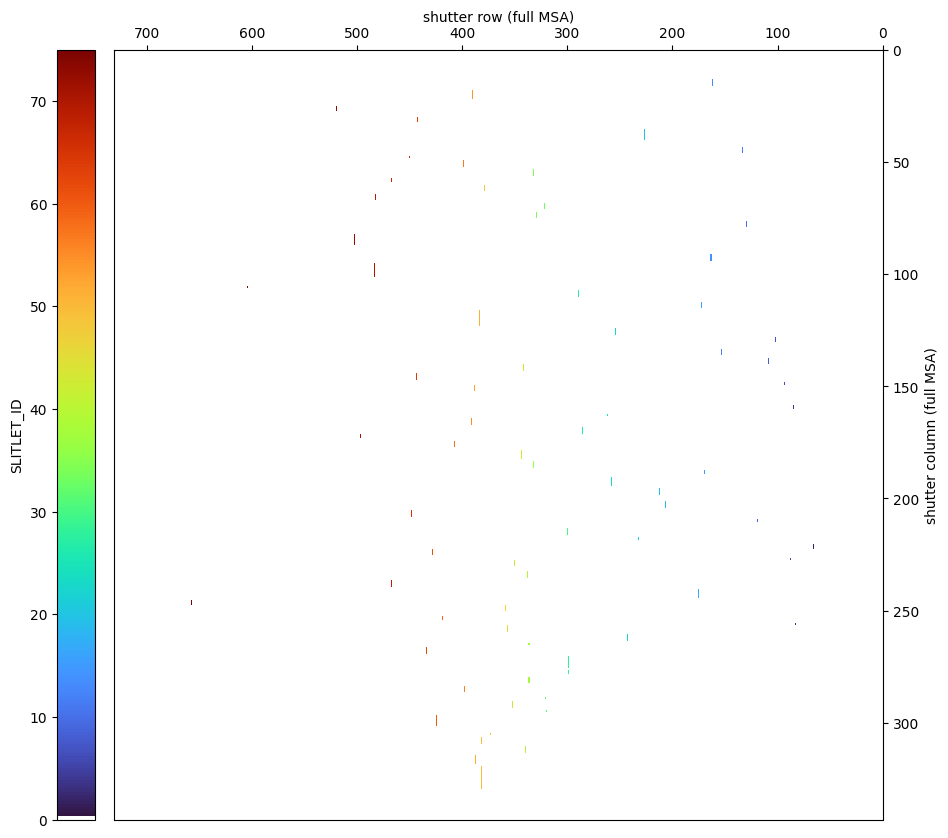

In [20]:
fig, ax = plt.subplots(figsize=(12, 10))
cmap = copy.deepcopy(mpl.colormaps['turbo'])
cmap.colors[0] = 1, 1, 1
extent = 0.5, nx+0.5, ny+0.5, 0.5  # origin=(1,1); range = 1..nx, 1..ny with +/-0.5 boundary on either side
im = plt.imshow(msa_image, aspect=nx/ny, interpolation='nearest', cmap=cmap, extent=extent)
plt.xlim(nx+1, 0)
plt.ylim(ny+1, 0)
plt.xlabel('shutter row (full MSA)')
plt.ylabel('shutter column (full MSA)')
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.xaxis.tick_top()
ax.xaxis.set_label_position("top")
cbar = fig.colorbar(im, ax=ax, shrink=1, aspect=20, pad=0.02, location='left')
cbar.set_label('SLITLET_ID')

---

#### 5.3.2 Shutter Image from Shutter Table <a id='image_table'></a>

In [21]:
# Extract quadrant, slitlet_id, row, and column from the filtered shutter table.
quadrant = shutter_table_dither1['shutter_quadrant']
slitlet = shutter_table_dither1['slitlet_id']

# Row, column resets within each quadrant.
row_in_quadrant = shutter_table_dither1['shutter_row']
column_in_quadrant = shutter_table_dither1['shutter_column']

# Row, column on full msa grid.
msa_row = row_in_quadrant + (quadrant > 2) * nx//2
msa_column = column_in_quadrant + even(quadrant) * ny//2

/tmp/ipykernel_2859/3474339455.py:13: UserWarning: Adding colorbar to a different Figure <Figure size 1200x1000 with 2 Axes> than <Figure size 1200x1000 with 2 Axes> which fig.colorbar is called on.
  cbar = fig.colorbar(im, ax=ax, shrink=1, aspect=20, pad=0.02, location='left')


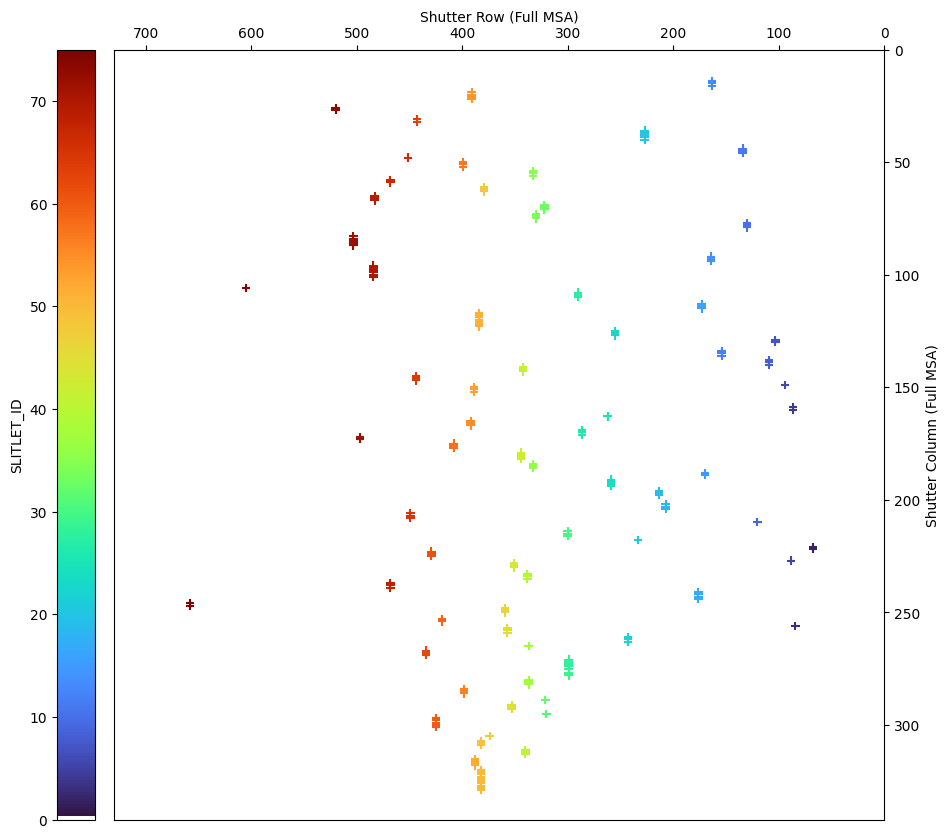

In [22]:
# Plot the shutter image from the shutter table.
fig, ax = plt.subplots(figsize=(12, 10))
plt.scatter(msa_row, msa_column, c=slitlet, marker='+', cmap=cmap, clim=(0, np.max(slitlet)))
plt.xlim(nx, 0)
plt.ylim(ny, 0)
plt.xlabel('Shutter Row (Full MSA)')
plt.ylabel('Shutter Column (Full MSA)')
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.xaxis.tick_top()
ax.xaxis.set_label_position("top")
ax.set_aspect(nx/ny)
cbar = fig.colorbar(im, ax=ax, shrink=1, aspect=20, pad=0.02, location='left')
cbar.set_label('SLITLET_ID')

---

#### 5.3.3 Shutter Image from APT <a id='image_apt'></a>

From APT –> MPT –> Plans –> Pointings –> Export Config.  
This returns a CSV file with a 2D map of all shutters for that MSA configuration:
* 1 = closed
* 0 = open

In [23]:
# Download the example MSA configuration file from APT.
msa_config_file = 'https://raw.githubusercontent.com/dancoe/NIRSpec_MOS_JWebbinar/main/data/2736.p1c1-2e1n1.csv'
msa_config_file = download_file(msa_config_file, data_dir)
msa_config_file

data/2736.p1c1-2e1n1.csv EXISTS


'data/2736.p1c1-2e1n1.csv'

In [24]:
with open(msa_config_file, 'r') as f:
    reader = csv.reader(f)
    msa_config_data = list(reader)
    
msa_config_data = np.array(msa_config_data[1:])  # remove first line header
msa_config_data = msa_config_data.astype(int).T

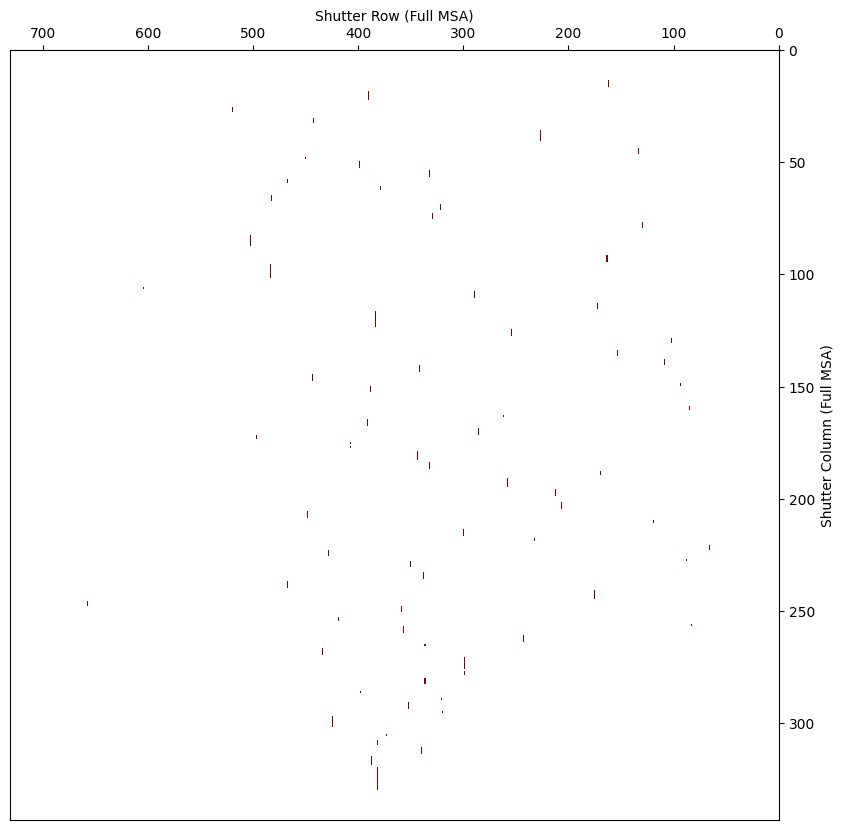

In [25]:
# Plot the shutter image from APT.
fig, ax = plt.subplots(figsize=(12, 10))
cmap = copy.deepcopy(mpl.colormaps['turbo'])
cmap.colors[0] = 1, 1, 1
extent = 0.5, nx+0.5, ny+0.5, 0.5  # origin=(1,1); range = 1..nx, 1..ny with +/-0.5 boundary on either side
im = plt.imshow(1 - msa_config_data, aspect=nx/ny, interpolation='nearest', extent=extent, cmap=cmap)
plt.xlim(nx+1, 0)
plt.ylim(ny+1, 0)
plt.xlabel('Shutter Row (Full MSA)')
plt.ylabel('Shutter Column (Full MSA)')
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.xaxis.tick_top()
ax.xaxis.set_label_position("top")

---

## 6. Modifying the MSA Metadata File <a id='modify'></a>


In this section, we demonstrate several types of modifications that can be made to the MSA metadata file, including:

* Trimming the metadata to a subset of objects (sources)
* Setting a source to be either point-like or extended
* Specifying background shutters

Finally, we will show how to save the modified MSA metadata file.



In the cell below, we trim the MSA metafile to a subset of objects.

In [26]:
#select_source_ids = -8, -9, -11, -12, -13, -16, -26, -27, -28, -29, -38, -41, -43, -57, -58, -59  # empty? backgrounds
select_source_ids = 6355, 5144, 4590, 10612, 8140, 9922  # Featured high-z galaxies.

select_source_table = filter_table(source_table,  source_id=select_source_ids)
select_shutter_table = filter_table(shutter_table, source_id=select_source_ids)

# See that only the sources of interest are in the table.
select_source_table

program,source_id,source_name,alias,ra,dec,preimage_id,stellarity
int32,int32,str20,str31,float64,float64,str30,float64
2736,4590,2736_4590,4590,110.85932870207512,-73.44916559196156,None,0.1
2736,5144,2736_5144,5144,110.83967390292369,-73.44535697626878,None,0.1
2736,6355,2736_6355,6355,110.84459416965377,-73.4350589621277,None,0.1
2736,8140,2736_8140,8140,110.78800223894049,-73.46186797161636,None,0.1
2736,9922,2736_9922,9922,110.85975635074477,-73.44421005964534,None,0.1
2736,10612,2736_10612,10612,110.83396490643933,-73.43452316524234,None,0.1



Next, we look at how to set a source to a point or an extended source. The Path loss correction step in the pipeline will use this information.

In [27]:
# Here we'll simply set them all to point source.
select_source_table['stellarity'] = 1  # 0 = extended; 1 = point source

# Check that the stellarity column has been updated.
select_source_table

program,source_id,source_name,alias,ra,dec,preimage_id,stellarity
int32,int32,str20,str31,float64,float64,str30,float64
2736,4590,2736_4590,4590,110.85932870207512,-73.44916559196156,None,1.0
2736,5144,2736_5144,5144,110.83967390292369,-73.44535697626878,None,1.0
2736,6355,2736_6355,6355,110.84459416965377,-73.4350589621277,None,1.0
2736,8140,2736_8140,8140,110.78800223894049,-73.46186797161636,None,1.0
2736,9922,2736_9922,9922,110.85975635074477,-73.44421005964534,None,1.0
2736,10612,2736_10612,10612,110.83396490643933,-73.43452316524234,None,1.0


Lastly, we will demonstrate how to set shutters to be identified as backgrounds. The pipeline will use this information to perform background subtraction. We could do this, but we won't, so we'll comment out these lines.

In [28]:
# Master Background.
#select_shutter_table['background']     = 'Y'
#select_shutter_table['primary_source'] = 'N'

Print out the modified source and shutter tables.

In [29]:
select_source_table

program,source_id,source_name,alias,ra,dec,preimage_id,stellarity
int32,int32,str20,str31,float64,float64,str30,float64
2736,4590,2736_4590,4590,110.85932870207512,-73.44916559196156,None,1.0
2736,5144,2736_5144,5144,110.83967390292369,-73.44535697626878,None,1.0
2736,6355,2736_6355,6355,110.84459416965377,-73.4350589621277,None,1.0
2736,8140,2736_8140,8140,110.78800223894049,-73.46186797161636,None,1.0
2736,9922,2736_9922,9922,110.85975635074477,-73.44421005964534,None,1.0
2736,10612,2736_10612,10612,110.83396490643933,-73.43452316524234,None,1.0


In [30]:
# Show contents but just for the first config and dither.
filter_table(select_shutter_table, msa_metadata_id=1, dither_point_index=1)

slitlet_id,msa_metadata_id,shutter_quadrant,shutter_row,shutter_column,source_id,background,shutter_state,estimated_source_in_shutter_x,estimated_source_in_shutter_y,dither_point_index,primary_source,fixed_slit
int16,int16,int16,int16,int16,int32,str1,str6,float32,float32,int16,str1,str7
16,1,1,173,113,8140,Y,OPEN,nan,nan,1,N,NONE
16,1,1,173,114,8140,N,OPEN,0.6575784,0.36736715,1,Y,NONE
16,1,1,173,115,8140,Y,OPEN,nan,nan,1,N,NONE
51,1,3,19,117,5144,Y,OPEN,nan,nan,1,N,NONE
51,1,3,19,118,5144,Y,OPEN,nan,nan,1,N,NONE
51,1,3,19,119,5144,Y,OPEN,nan,nan,1,N,NONE
51,1,3,19,120,5144,Y,OPEN,nan,nan,1,N,NONE
51,1,3,19,121,5144,N,OPEN,0.51558393,0.08815128,1,Y,NONE
51,1,3,19,122,5144,Y,OPEN,nan,nan,1,N,NONE


Save the modified MSA metafile with the same filename as the original, but in a new directory.

In [31]:
# Create the new output directory if it does not yet exist.
output_dir = 'reprocess_subset'
os.makedirs(output_dir, exist_ok=True)

# Add the new directory to the output filename.
output_msa_metafile = os.path.join(output_dir, msa_metafile_name)
output_msa_metafile

'reprocess_subset/jw02736007001_01_msa.fits'

In [32]:
msa_hdu_list.info()

Filename: data/jw02736007001_01_msa.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      16   ()      
  1  SHUTTER_IMAGE    1 ImageHDU         8   (342, 730)   int16   
  2  SHUTTER_INFO    1 BinTableHDU     35   1318R x 13C   ['I', 'I', 'I', 'I', 'I', 'J', '1A', '6A', 'E', 'E', 'I', '1A', '7A']   
  3  SOURCE_INFO    1 BinTableHDU     25   119R x 8C   ['J', 'J', '20A', '31A', 'D', 'D', '30A', 'D']   


In [33]:
# Convert tables to HDUs and add to the HDU List.
msa_hdu_list['SHUTTER_INFO'] = fits.table_to_hdu(select_shutter_table)
msa_hdu_list['SOURCE_INFO'] = fits.table_to_hdu(select_source_table)

msa_hdu_list[2].name = 'SHUTTER_INFO'
msa_hdu_list[3].name = 'SOURCE_INFO'

msa_hdu_list.info()

Filename: data/jw02736007001_01_msa.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      16   ()      
  1  SHUTTER_IMAGE    1 ImageHDU         8   (342, 730)   int16   
  2  SHUTTER_INFO    1 BinTableHDU     35   144R x 13C   ['I', 'I', 'I', 'I', 'I', 'J', '1A', '6A', 'E', 'E', 'I', '1A', '7A']   
  3  SOURCE_INFO    1 BinTableHDU     25   6R x 8C   ['J', 'J', '20A', '31A', 'D', 'D', '30A', 'D']   


In [34]:
print('SAVING', output_msa_metafile)
msa_hdu_list.writeto(output_msa_metafile, overwrite=True)
#msa_hdu_list.close()  # let's keep this open to use below.

SAVING reprocess_subset/jw02736007001_01_msa.fits


---

## 7. Link to Files in Preparation for Pipeline <a id='pipeline'></a>

We won't run the pipeline in this notebook, but this shows you how to prepare.  
When you run the pipeline on these linked files in this new directory, it will find the updated metafile there.

In [35]:
rate_files = sorted(glob(os.path.join(data_dir, '*_rate.fits*')))
link_to_files(rate_files, output_dir)

In [36]:
asn_files = sorted(glob(os.path.join(data_dir, '*_asn.json')))
link_to_files(asn_files, output_dir)



---
[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/>